## Install Libraries

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

## Load the dataset

In [33]:
df = pd.read_csv("server_usage.csv")

print(df.head())
df.columns.values

   41700  237  23.3799999237  30.08000030518  42.2000007629  \
0  39600  265          26.36       29.540000      57.599998   
1  42600  770          49.14       60.099999      41.860001   
2  40800  776          33.24       47.520000      43.599998   
3  42900  393          45.72       58.720000      42.000000   
4  39600  610          41.70       59.220001      42.599998   

   15.820000267020001  13.860000038159999  12.64000015258  
0               17.46           18.900000           16.70  
1               33.20           31.220000           30.52  
2               21.84           22.100000           24.02  
3               34.10           36.239999           36.92  
4               29.86           29.400000           25.50  


array(['41700', '237', '23.3799999237', '30.08000030518', '42.2000007629',
       '15.820000267020001', '13.860000038159999', '12.64000015258'],
      dtype=object)

## Load and Preoprocess dataset

In [23]:
def preprocess_data(file_path, sequence_length=10, test_size=0.2):
    df = pd.read_csv(file_path, header=None)
    df.columns = [
        "timestamp", "machine_id", "cpu_usage", "memory_usage",
        "disk_usage", "load1", "load5", "load15"
    ]
    
    machine_id = 1
    df = df[df["machine_id"] == machine_id].reset_index(drop=True)
    
    features = df[["cpu_usage", "memory_usage", "disk_usage", "load1", "load5", "load15"]].values
    target = df["cpu_usage"].values.reshape(-1, 1)
    
    # Normalize both features and target
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()
    
    features = feature_scaler.fit_transform(features)
    target = target_scaler.fit_transform(target)
    
    X, y = create_sequences(features, target.flatten(), sequence_length)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, shuffle=False
    )
    return X_train, X_test, y_train, y_test, feature_scaler, target_scaler

## Create Sequences for time-series data

In [24]:
def create_sequences(features, target, sequence_length):
    X, y = [], []
    for i in range(len(features) - sequence_length):
        X.append(features[i:i+sequence_length])  # Collect sequences of features
        y.append(target[i+sequence_length])  # Collect corresponding targets
    return np.array(X), np.array(y)

## LSTM Model

In [25]:
class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        attention_weights = F.softmax(self.attention(x), dim=1)
        context_vector = torch.sum(attention_weights * x, dim=1)
        return context_vector

class InfrastructureLSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, num_layers=2, output_dim=1, dropout=0.3):
        super(InfrastructureLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Input layer
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        
        # LSTM layers with residual connections
        self.lstm_layers = nn.ModuleList([
            nn.LSTM(hidden_dim, hidden_dim, 1, batch_first=True, dropout=dropout)
            for _ in range(num_layers)
        ])
        
        # Attention layer
        self.attention = AttentionLayer(hidden_dim)
        
        # Output layers
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)
        
        # Layer normalization
        self.layer_norm = nn.LayerNorm(hidden_dim)
        
    def forward(self, x):
        # Input projection
        x = self.input_layer(x)
        
        # Process LSTM layers with residual connections
        h = x
        for lstm in self.lstm_layers:
            lstm_out, _ = lstm(h)
            h = lstm_out + h  # Residual connection
            h = self.layer_norm(h)  # Layer normalization
        
        # Apply attention
        context = self.attention(h)
        
        # Output layers
        out = self.fc1(context)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

## Training

In [26]:
def train_model(X_train, y_train, X_test, y_test, sequence_length, epochs=100, batch_size=32, lr=1e-3):
    # Convert data to PyTorch tensors
    train_dataset = TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_test, y_test = X_test.to(device), y_test.to(device)
    
    # Initialize model, loss, and optimizer
    model = InfrastructureLSTM(input_dim=6, hidden_dim=128).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    
    best_test_loss = float('inf')
    train_losses, test_losses = [], []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_losses.append(test_loss.item())
            
            # Save best model
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                torch.save(model.state_dict(), 'best_model.pt')
        
        scheduler.step(test_loss)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {test_loss.item():.4f}")
    
    return model, train_losses, test_losses

## Plot training and test losses

In [27]:
# Plot training and test losses
def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Test Loss Over Epochs")
    plt.show()


## Main Function

C:\Users\91965\anaconda3\envs\infra-env\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 0/50, Train Loss: 0.6206, Test Loss: 0.1313
Epoch 10/50, Train Loss: 0.0304, Test Loss: 0.0333
Epoch 20/50, Train Loss: 0.0278, Test Loss: 0.0291
Epoch 30/50, Train Loss: 0.0258, Test Loss: 0.0323
Epoch 40/50, Train Loss: 0.0263, Test Loss: 0.0315


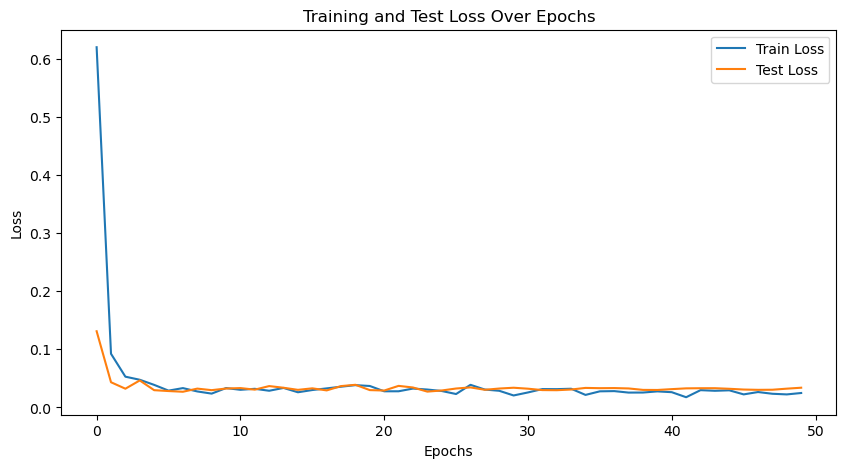


Metrics on original scale:
RMSE: 6.33
MAE: 5.35


In [32]:
def main():
    # File path to server_usage.csv
    file_path = "server_usage.csv"
    
    # Parameters
    sequence_length = 10
    epochs = 50
    batch_size = 32  # Add this parameter
    learning_rate = 1e-3
    
    # Preprocess data
    X_train, X_test, y_train, y_test, feature_scaler, target_scaler = preprocess_data(file_path, sequence_length)
    
    # Train the model - fix parameter order
    model, train_losses, test_losses = train_model(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        sequence_length=sequence_length,
        epochs=epochs, 
        batch_size=batch_size,  # Add batch_size
        lr=learning_rate
    )
    
    # Plot losses
    plot_losses(train_losses, test_losses)
    
    # Calculate metrics on original scale
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        model.eval()
        y_pred = model(torch.tensor(X_test, dtype=torch.float32).to(device))
        y_pred = y_pred.cpu().numpy()
        
        # Transform predictions back to original scale
        y_pred = target_scaler.inverse_transform(y_pred)
        y_test_orig = target_scaler.inverse_transform(y_test.reshape(-1, 1))
        
        rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
        mae = mean_absolute_error(y_test_orig, y_pred)
        print(f"\nMetrics on original scale:")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")

if __name__ == "__main__":
    main()